# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
import random
import numpy as np
import pandas as pd
import math 

import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt

import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from IPython.display import display
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2077,1,49.0,37900.0,5,1
3372,0,42.0,23000.0,2,0
4516,1,28.0,38100.0,0,0
2882,1,37.0,42300.0,1,0
2033,1,25.0,50900.0,0,0
4397,0,34.0,42200.0,0,0
1120,1,33.0,21700.0,3,0
1431,0,19.0,14400.0,2,0
2483,1,33.0,53000.0,1,0
193,0,23.0,43600.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:

df['age'] = df['age'].astype(int)

In [7]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


En la descripción de los datos veo que todas las columnas estan completas, no hay datos faltantes.

En la columna ´age´ la edad media es 30 años con una varianza +- de 8 años. La edad mínima es 18 años y la edad máxima es 65 años.

En la columna ´income´ el ingreso medio es de 40000 dólares con una variabilidad mayor o menor de 1000 dólares. 

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

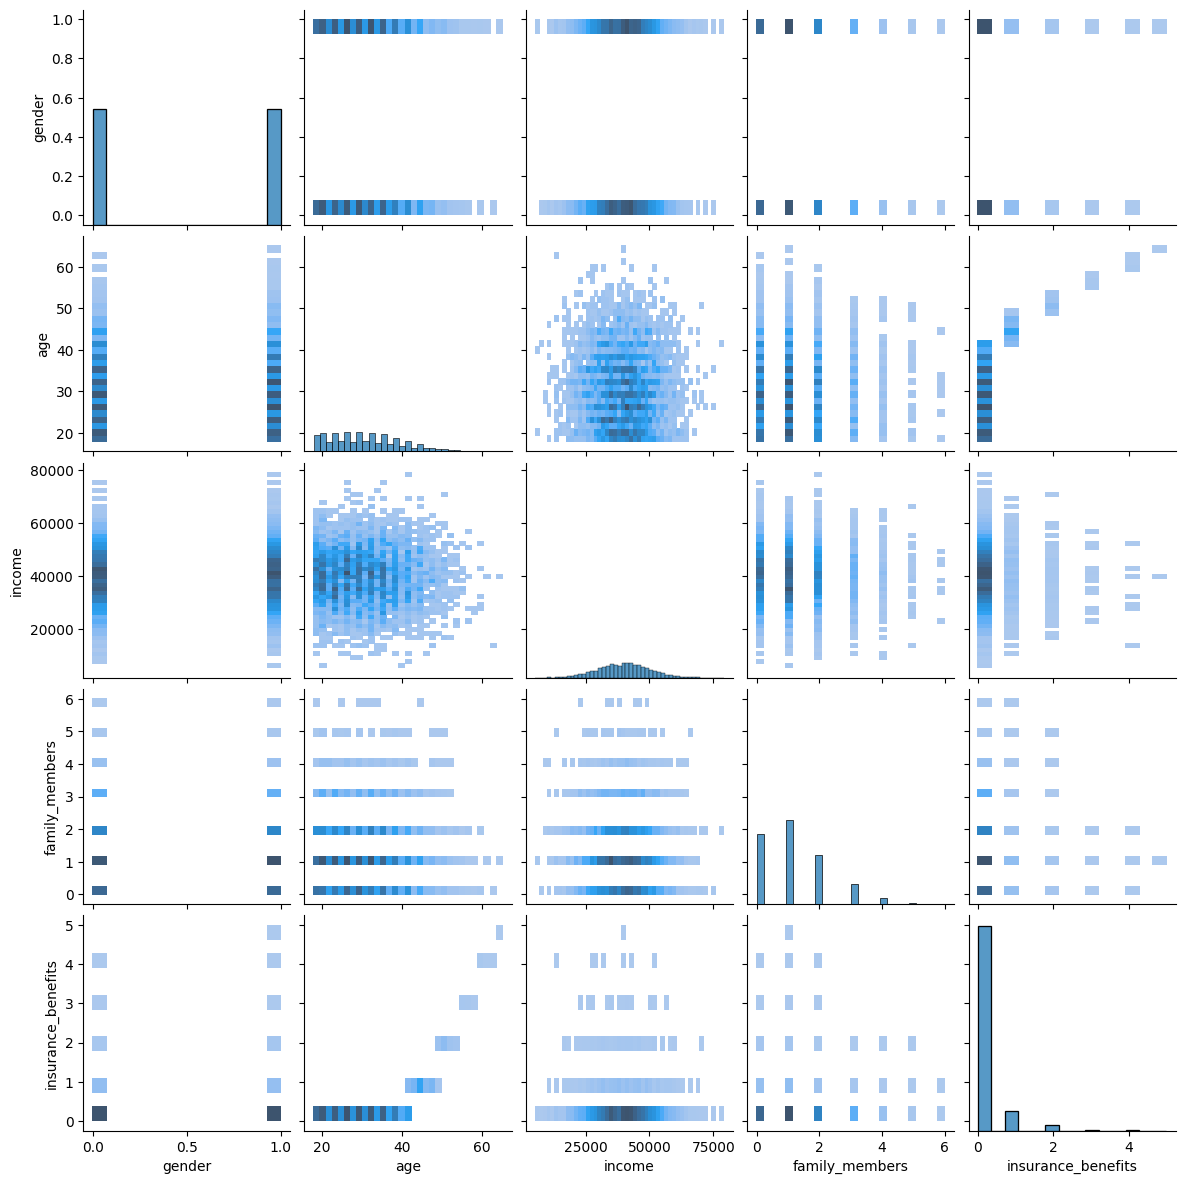

In [9]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [10]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [11]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    
    :param n: número de objetos para los que se buscan los vecinos más cercanos   
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    model = df[feature_names].values
    
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(model)
    
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [13]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4932,0.0,0.584615,0.578481,0.333333,0
3961,0.0,0.430769,0.525316,0.166667,0
2106,1.0,0.307692,0.456962,0.000000,0
2370,1.0,0.600000,0.624051,0.500000,0
493,1.0,0.523077,0.554430,0.333333,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [14]:
get_knn(df_scaled, n=10, k=5, metric= 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
10,1.0,0.384615,0.463291,0.166667,0,0.000000
4377,1.0,0.384615,0.473418,0.166667,0,0.010127
1389,1.0,0.369231,0.464557,0.166667,0,0.015437
760,1.0,0.369231,0.462025,0.166667,0,0.015437
2254,1.0,0.400000,0.455696,0.166667,0,0.017157


In [15]:
get_knn(df_scaled, n=10, k=5, metric= 'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
10,1.0,0.384615,0.463291,0.166667,0,0.000000
4377,1.0,0.384615,0.473418,0.166667,0,0.010127
1389,1.0,0.369231,0.464557,0.166667,0,0.016650
760,1.0,0.369231,0.462025,0.166667,0,0.016650
2254,1.0,0.400000,0.455696,0.166667,0,0.022980


In [16]:
get_knn(df, n=10, k=5, metric= 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
10,1,25,36600.0,1,0,0.000000
4039,1,25,36600.0,2,0,1.000000
2037,1,26,36600.0,0,0,1.414214
3247,1,26,36600.0,2,0,1.414214
1508,0,26,36600.0,0,0,1.732051


In [17]:
get_knn(df, n=10, k=5, metric= 'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
10,1,25,36600.0,1,0,0.0
4039,1,25,36600.0,2,0,1.0
2037,1,26,36600.0,0,0,2.0
3247,1,26,36600.0,2,0,2.0
1508,0,26,36600.0,0,0,3.0


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Sí, el hecho de que los datos no estén escalados afecta significativamente al algoritmo kNN. Porque este calcula las distancias entre los puntos de datos para determinar qué vecinos cercanos son los más similares a un punto dado. Si las características (o variables) tienen diferentes escalas o unidades, algunas características tendrán una influencia mucho mayor en el cálculo de la distancia, lo que puede distorsionar los resultados del algoritmo.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Independientemente de si los datos están escalados o no, los resultados de kNN usando la métrica Manhattan pueden ser similares a los de la distancia euclidiana, pero hay algunas diferencias notables en cómo se comporta el modelo, debido a las características de cada métrica. Observamos que en el primer y segundo grupo se mantienen iguales, empezando a verse cambios a partir del tercer grupo.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [18]:
# сalcula el objetivo
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [19]:
# comprueba el desequilibrio de clases con value_counts()
df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [20]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo  
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [21]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [22]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    
    y_pred_rnd = rnd_model_predict(P, size=len(df))
   
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



In [23]:
features = df[['age', 'gender', 'income', 'family_members']].to_numpy()
target = df['insurance_benefits_received'].to_numpy()

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)

In [24]:
# Escalar los datos
scaler = MaxAbsScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [25]:
# Lista para almacenar los resultados
f1_scores_knn_original = []
f1_scores_knn_scaled = []

# Evaluación para k=1 hasta k=10
for k in range(1, 11):
    # Modelo kNN para datos originales
    knn_original = KNeighborsClassifier(n_neighbors=k)
    knn_original.fit(features_train, target_train)
    y_pred_original = knn_original.predict(features_test)
    f1_knn_original = f1_score(target_test, y_pred_original)
    f1_scores_knn_original.append(f1_knn_original)
    
    # Modelo kNN para datos escalados
    knn_scaled = KNeighborsClassifier(n_neighbors=k)
    knn_scaled.fit(features_train_scaled, target_train)
    y_pred_scaled = knn_scaled.predict(features_test_scaled)
    f1_knn_scaled = f1_score(target_test, y_pred_scaled)
    f1_scores_knn_scaled.append(f1_knn_scaled)


In [26]:
# Imprimir los resultados para los datos originales y escalados
print("F1 Scores para los datos originales:")
for k, f1_score in zip(range(1, 11), f1_scores_knn_original):
    print(f'k={k}: {f1_score:.4f}')

print("\nF1 Scores para los datos escalados:")
for k, f1_score in zip(range(1, 11), f1_scores_knn_scaled):
    print(f'k={k}: {f1_score:.4f}')

F1 Scores para los datos originales:
k=1: 0.6071
k=2: 0.4057
k=3: 0.4071
k=4: 0.2784
k=5: 0.2714
k=6: 0.1143
k=7: 0.1130
k=8: 0.0710
k=9: 0.0824
k=10: 0.0000

F1 Scores para los datos escalados:
k=1: 0.9659
k=2: 0.9281
k=3: 0.9494
k=4: 0.9079
k=5: 0.9241
k=6: 0.9037
k=7: 0.9201
k=8: 0.9013
k=9: 0.9156
k=10: 0.8792


- Predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy? 

Definitivamente si, al fijarnos en el f1 score de ambos modelos vemos que el mayor valor es 0.20 en el modelo dummy. Y en el modelo knn con los datos originales es de 0.60, y de 0.96 con los datos escalados.

Por lo tanto, el modelo knn obtiene un mejor balance entre precisión y recall en comparación con el modelo dummy.


# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [27]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y # <tu código aquí>

    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1) # <tu código aquí>
        y_pred = X2 @ self.weights # <tu código aquí>
        
        return y_pred

In [28]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    

    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [29]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [30]:
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Entrenar el modelo con los datos escalados
model = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train_scaled, y_train)

# Hacer predicciones con los datos de prueba
y_pred = model.predict(X_test_scaled)


In [32]:
# Calcular RMSE para los datos escalados
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
rmse_scaled = np.sqrt(mse_scaled)
print(f"RMSE con datos escalados: {rmse_scaled}")

RMSE con datos escalados: 0.2695675549220764


Vemos que el error se reduce con los datos escalados.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [33]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [34]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [35]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [36]:
# Verificar si la matriz es invertible comprobando su determinante
determinante = np.linalg.det(P)

# Si el determinante es distinto de cero, la matriz es invertible
if determinante != 0:
    print("La matriz P es invertible.")
else:
    print("La matriz P no es invertible.")

La matriz P es invertible.


¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [37]:
T = X @ P

In [38]:
dfT = pd.DataFrame(T, columns=df_pn.columns)
df2 = pd.concat([df, dfT], axis=1, keys=['original', 'transformed'])

In [39]:
df2.sample(5)

original                                                 \
       gender age   income family_members insurance_benefits   
1031        1  22  50100.0              1                  0   
1314        0  22  47700.0              0                  0   
3280        0  34  41500.0              1                  0   
1575        0  31  35400.0              2                  0   
4556        0  23  23000.0              1                  0   

                                  transformed                              \
     insurance_benefits_received       gender           age        income   
1031                           0  6421.982720  22587.060820  18595.028100   
1314                           0  6113.092180  21504.872929  17703.810829   
3280                           0  5320.561651  18725.010344  15414.440170   
1575                           0  4539.429825  15975.552018  13150.732217   
4556                           0  2949.423496  10382.138647   8546.304185   

                     
     family_members  
1031   46449.143963  
1314   44223.983383  
3280   38487.700462  
1575   32832.303076  
4556   21333.901461

No se puede tener una idea de cual seria los datos originales, al solo ver los transformados.

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [40]:
P_inv = np.linalg.inv(P)

X_recovered = np.dot(T, P_inv)

dfn = pd.DataFrame(X_recovered, columns=df_pn.columns)
df3 = pd.concat([df_pn, dfT, dfn], axis=1, keys=['original', 'transformed', 'reversed'])

Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [41]:
df3.sample(5)

original                              transformed                \
       gender age   income family_members       gender           age   
955         1  28  39700.0              0  5089.522139  17908.078039   
863         1  42  23500.0              1  3016.043638  10626.307319   
2354        1  52  16400.0              2  2108.022484   7439.146145   
4453        0  19  21400.0              0  2743.421109   9656.795896   
1297        0  31  43400.0              2  5564.338886  19578.639521   

                                       reversed                                
            income family_members        gender   age   income family_members  
955   14742.852072   36815.277226  1.000000e+00  28.0  39700.0   4.088690e-12  
863    8747.023449   21812.916546  1.000000e+00  42.0  23500.0   1.000000e+00  
2354   6122.412288   15240.973006  1.000000e+00  52.0  16400.0   2.000000e+00  
4453   7949.539373   19847.705983 -1.139886e-12  19.0  21400.0   1.437744e-13  
1297  16117.116411   40246.422987 -5.304395e-12  31.0  43400.0   2.000000e+00

In [42]:
df3.sample(5).astype('int')

original                           transformed                \
       gender age income family_members      gender    age income   
4235        1  28  50900              1        6525  22953  18896   
748         1  31  51600              0        6614  23270  19157   
3181        1  25  51900              0        6652  23399  19264   
4615        1  28  16300              1        2092   7369   6066   
4895        1  38  35200              2        4515  15892  13082   

                    reversed                            
     family_members   gender age income family_members  
4235          47195        0  28  50899              1  
748           47846        0  30  51599              0  
3181          48119        0  24  51900              0  
4615          15129        0  27  16300              0  
4895          32653        0  37  35200              1

Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Vemos que todos los valores enteros se conirtieron a números decimales, ya que durante el proceso de transformación todas las cifras terminaron con una parte decimal. Algunos valores que deberían ser cero no lo son exactamente, debido a las restricciones en la precisión numérica.

Veamos si los valores de las características, tanto originales como transformados, están relacionados entre sí.

gender          r= 0.01, p=0.36
age             r=-0.02, p=0.22
income          r= 1.00, p=0.00
family_members  r=-0.03, p=0.07


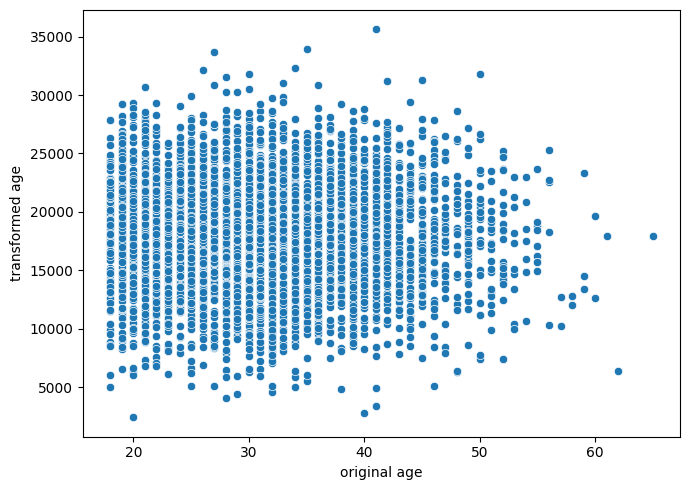

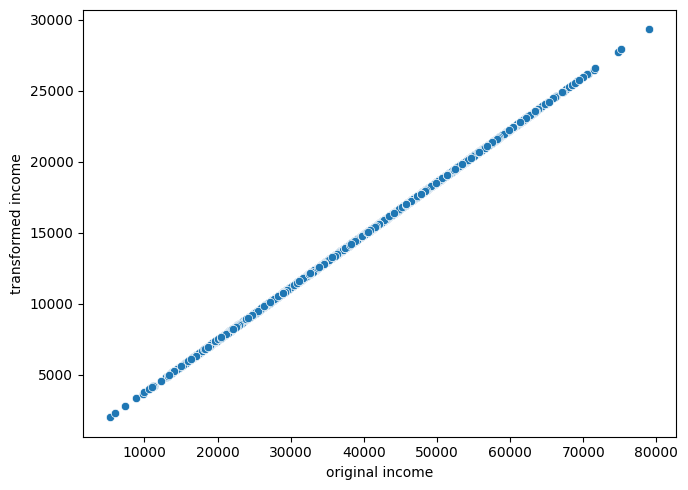

In [43]:
for name in personal_info_column_list:
    r, p = scipy.stats.spearmanr(df3['original'][name], df3['transformed'][name])
    print(f'{name:15} r={r:5.2f}, p={p:.2f}')

fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(x=df3['original']['age'], y=df3['transformed']['age'], ax=ax)
ax.set_xlabel('original age')
ax.set_ylabel('transformed age')
fig.tight_layout()

fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(x=df3['original']['income'], y=df3['transformed']['income'], ax=ax)
ax.set_xlabel('original income')
ax.set_ylabel('transformed income')
fig.tight_layout()

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

La relación entre $w$ y $w_P$ se puede entender como una transformación lineal de los pesos, que depende de la matriz 
𝑃.

¿Cuáles serían los valores predichos con $w_P$? 

Los valores predichos con  $w_P$ son una versión modificada de los valores predichos con 𝑤, que dependerán de cómo 𝑃 transforma las características.

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?

El impacto en la calidad de la regresión (medida por la RECM) dependerá de si la matriz 𝑃 es invertible y de su influencia en el modelo. Si 𝑃 no es invertible, los errores podrían aumentar y, por lo tanto, la RECM también podría aumentar.

**Prueba analítica**

Simplificación de $w_P$  :

Si la transformación de $ X $ a \( $X_P$ \) es lineal, es decir, $ X_P = A X $ para alguna matriz $ A $ de transformación, entonces podemos expresar la relación entre $ w $ y  $w_P$  de la siguiente forma:

$$ w_P = [(A X)^T A X]^{-1} (A X)^T y $$

Reorganizando:


$$ w_P = [X^T A^T A X]^{-1} X^T A^T y $$


Si $ A^T A $ es la matriz identidad (lo que ocurre si $ A $ es una matriz ortogonal), entonces la fórmula se simplifica a:

$$ w_P = (X^T X)^{-1} X^T y $$

Por lo tanto, en este caso particular donde $ A^T A = I $, $ w_P $ sería igual a $ w $, es decir:

$$ w_P = w $$ 

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <Multiplica la matriz $X$ por la matriz $P$>
- Utiliza $XP$ como la nueva matriz de características

In [44]:
# Matriz Original

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

eval_regressor(y_test, y_pred_test)

RMSE: 0.34
R2: 0.66


In [45]:
# Matriz cuadrada 𝑃 de números aleatorios

def es_invertible(matriz):
    try:
        np.linalg.inv(matriz)
        return True
    except np.linalg.LinAlgError:
        return False

# Función para crear una matriz P invertible
def generar_matriz_P(tamaño):
    while True:
        P = np.random.rand(tamaño, tamaño) 
        if es_invertible(P):
            return P

# Generar la matriz P invertible
P = generar_matriz_P(X.shape[1])

In [46]:
X_train_ofuscado = X_train @ P
X_test_ofuscado = X_test @ P

model_ofuscado = LinearRegression()

model_ofuscado.fit(X_train_ofuscado, y_train)

y_ofus_pred_train = model_ofuscado.predict(X_train_ofuscado)
y_ofus_pred_test = model_ofuscado.predict(X_test_ofuscado)

eval_regressor(y_test, y_ofus_pred_test)


RMSE: 0.34
R2: 0.66


A pesar de que la matriz original haya sido ofuscada, al aplicar la regresión lineal, no hubo ninguna diferencia en los valores de las metricas. Teniendo ambas matrices un RMSE de 0.34 y un R2 de 0.66

# Conclusiones

- El algoritmo de k vecinos (kNN) se basa en la idea de que los objetos similares estarán cerca unos de otros en el espacio de características. Siempre hay que tener los valores de las caracteristicas a evaluar, ya que para una clasificación más precisa, es necesario escalar los datos. Y dependiendo del tipo de datos con los que se maneje, es necesario escoger una distancia Manhattan o Euclidiana.

- Cuando hemos trabajamos con matrices hemos vistos que los resultados no siempre serán exactos, ya que no hay un límite en la precisión con la que se realizan los cálculos. Esto es especialmente evidente en operaciones que involucran decimales o números grandes, debido a la forma en que se representan y almacenan los números de manera aproximada.

- A veces necesitamos transformar nuestros datos (características) para que sean más fáciles de manejar por los algoritmos. Si usamos una matriz invertible (es decir, una matriz cuya inversión es posible), podemos transformar las características sin que esto altere la capacidad de los algoritmos para hacer predicciones. La regresión lineal es un buen ejemplo: aunque transformemos los datos con una matriz, los valores que predice el modelo no cambiarán.